# ISOT Dataset

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import joblib
import time

# Change directory to where the dataset is located
%cd /content/drive/MyDrive/MS983/Datasets/
ISOTdf = pd.read_csv('ISOT/FullyCleanISOT.csv')
texts = ISOTdf['text'].fillna('').tolist()
y = ISOTdf['label'].astype(int).values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

# Set up the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 3))

# Define the pipelines for different classifiers
pipe_lr = Pipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", LogisticRegression(max_iter=1000))
])

pipe_svm = Pipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", LinearSVC())
])

pipe_rf = Pipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", RandomForestClassifier(random_state=42))
])

pipe_nb = Pipeline([
    ("tfidf", tfidf_vectorizer),
    ("clf", MultinomialNB())
])


/content/drive/MyDrive/MS983/Datasets


In [22]:
# Hyperparameter tuning for Logistic Regression
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100], # Regularization strength
    'clf__solver': ['liblinear', 'saga'], # Solvers for optimization
    'clf__penalty': ['l2'], # Penalty type
    'clf__class_weight': [None, 'balanced'] # Class weights for handling class imbalance
}

grid_lr = GridSearchCV(pipe_lr, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression Parameters:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

Best Logistic Regression Parameters: {'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'saga'}


In [23]:
# Hyperparameter tuning for SVM
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10], # Regularization strength
    'clf__class_weight': [None, 'balanced'], # Class weights for handling class imbalance
    'clf__max_iter': [1000, 2000] # Maximum number of iterations for convergence
}

grid_svm = GridSearchCV(pipe_svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_svm.fit(X_train, y_train)

print("Best SVM Parameters:", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_

Best SVM Parameters: {'clf__C': 1, 'clf__class_weight': None, 'clf__max_iter': 1000}


In [24]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'clf__n_estimators': [100, 200], # Number of trees in the forest
    'clf__max_depth': [None, 20, 50], # Maximum depth of the tree
    'clf__min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'clf__min_samples_leaf': [1, 2], # Minimum number of samples required to be at a leaf node
    'clf__class_weight': [None, 'balanced'] # Class weights for handling class imbalance
}

grid_rf = GridSearchCV(pipe_rf, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best Random Forest Parameters:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

Best Random Forest Parameters: {'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}


In [25]:
# Hyperparameter tuning for Naive Bayes
param_grid = {
    'clf__alpha': [0.1, 0.5, 1.0, 2.0] # Smoothing parameter for Naive Bayes
}

grid_nb = GridSearchCV(pipe_nb, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_nb.fit(X_train, y_train)

print("Best Naive Bayes Parameters:", grid_nb.best_params_)
best_nb = grid_nb.best_estimator_

Best Naive Bayes Parameters: {'clf__alpha': 0.1}


In [26]:
# Store the best models in a dictionary for easy access
models = {
    'Logistic Regression': best_lr,
    'SVM': best_svm,
    'Naive Bayes': best_nb,
    'Random Forest': best_rf
}

# Evaluate each model on the test set
for name, model in models.items():
    print(f"\n{name}")

    # Test Performance & Timing
    start_test = time.time()
    y_test_pred = model.predict(X_test)
    end_test = time.time()
    test_inference_time = end_test - start_test
    test_avg_time = test_inference_time / len(X_test)

    print("Test Performance:")
    print(classification_report(y_test, y_test_pred))
    print(f"Test inference time: {test_inference_time:.4f} seconds")
    print(f"Average time per test sample: {test_avg_time:.6f} seconds")


Logistic Regression
Test Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4694
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978

Test inference time: 3.8801 seconds
Average time per test sample: 0.000432 seconds

SVM
Test Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4694
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978

Test inference time: 3.8312 seconds
Average time per test sample: 0.000427 seconds

Naive Bayes
Test Performance:
              precision    recall  f1-score   support

           0       0.96      0.9


Logistic Regression


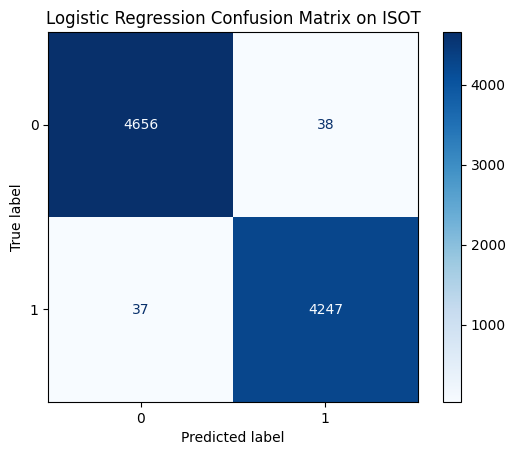


SVM


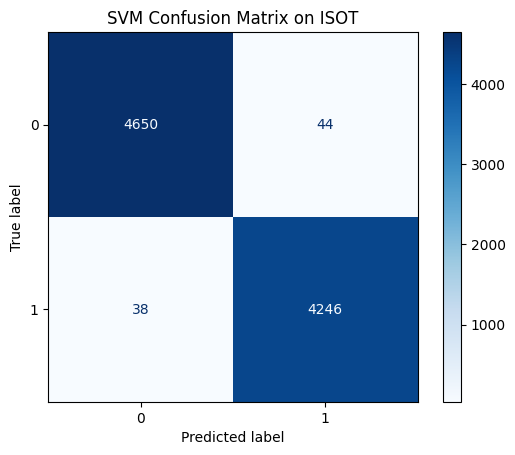


Naive Bayes


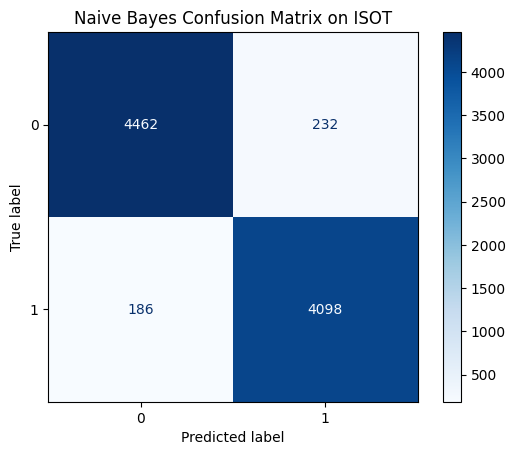


Random Forest


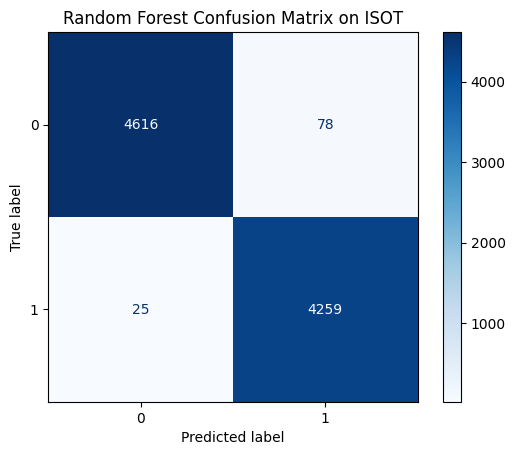

In [27]:
# Evaluate confusion matrix for each model
for name, model in models.items():
    print(f"\n{name}")

    # Make predictions for this model
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int).ravel()

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix on ISOT")
    plt.show()


Logistic Regression ROC Curve


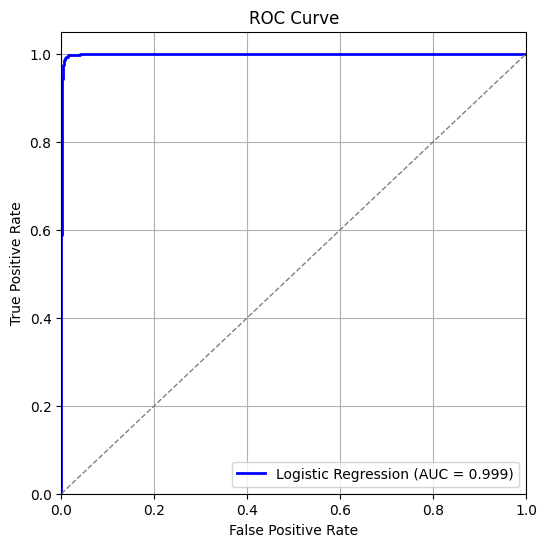


SVM ROC Curve


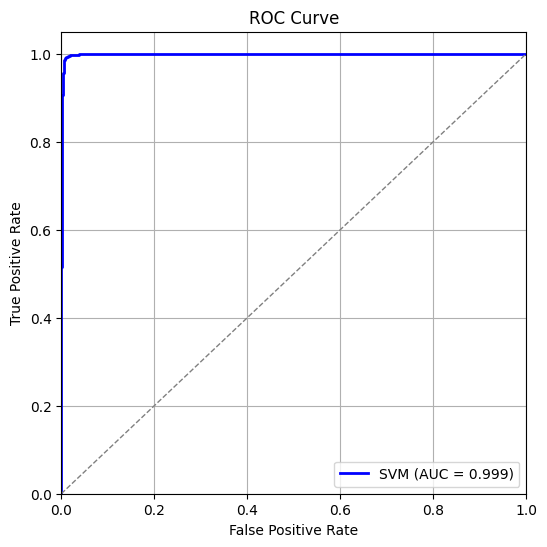


Naive Bayes ROC Curve


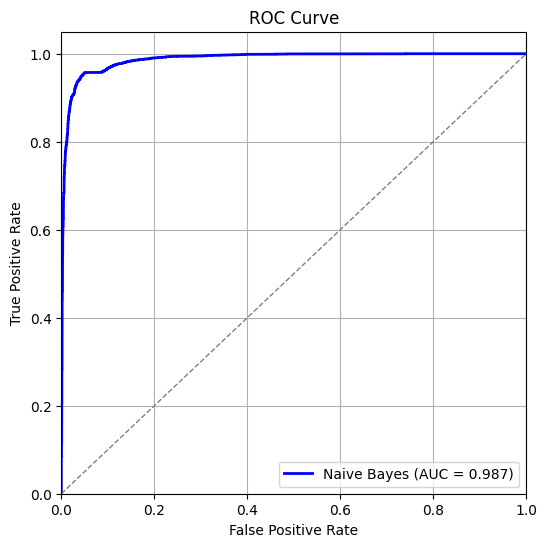


Random Forest ROC Curve


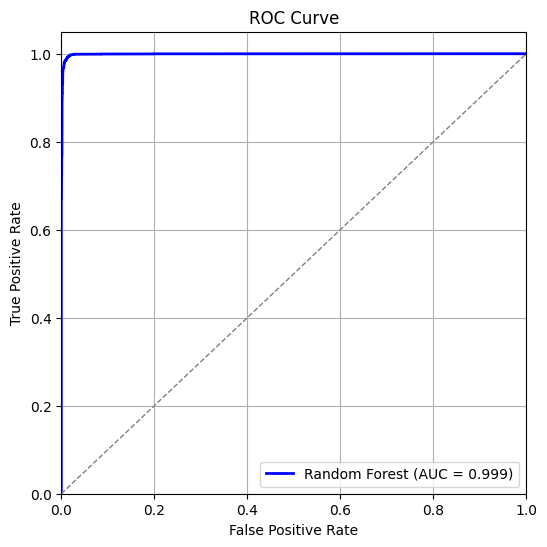

In [28]:
# Plot ROC curves for each model
for name, model in models.items():
    print(f"\n{name} ROC Curve")

    # Get model scores
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    elif hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:  # e.g., Keras or models with only predict
        y_scores = model.predict(X_test)
        if y_scores.ndim > 1:  # if output is 2D, take positive class column
            y_scores = y_scores[:, 1]
        y_scores = np.ravel(y_scores)

    # Compute ROC and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [29]:
%cd /content/drive/MyDrive/MS983/Models/

# Save the TF-IDF vectorizer and the best models
joblib.dump(tfidf_vectorizer, "ISOT_tfidf.joblib")
joblib.dump(best_svm, "ISOT_SVM_model.joblib")
joblib.dump(best_lr, "ISOT_LR_model.joblib")


/content/drive/MyDrive/MS983/Models


['ISOT_LR_model.joblib']

# LIAR Dataset

In [30]:
%cd /content/drive/MyDrive/MS983/Datasets/

# Load the LIAR dataset
liardf = pd.read_csv('LIAR/FullyCleanedLIAR.csv')

# Masks as NumPy arrays
mask_train = liardf['dataset'].isin([0, 1]).to_numpy()
mask_test  = (liardf['dataset'].to_numpy() == 2)

# Statements
X_train = liardf.loc[mask_train, 'statement'].fillna('')
X_test = liardf.loc[mask_test, 'statement'].fillna('')

# Labels
y_train = liardf.loc[mask_train, 'label_binary'].to_numpy()
y_test  = liardf.loc[mask_test,  'label_binary'].to_numpy()


/content/drive/MyDrive/MS983/Datasets


In [31]:
# Hyperparameter tuning for Logistic Regression
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__solver': ['liblinear', 'saga'],
    'clf__penalty': ['l2'],
    'clf__class_weight': [None, 'balanced']
}

grid_lr = GridSearchCV(pipe_lr, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best Logistic Regression Parameters:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

Best Logistic Regression Parameters: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'saga'}


In [32]:
# Hyperparameter tuning for SVM
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__class_weight': [None, 'balanced'],
    'clf__max_iter': [1000, 2000]
}

grid_svm = GridSearchCV(pipe_svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_svm.fit(X_train, y_train)

print("Best SVM Parameters:", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_

Best SVM Parameters: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__max_iter': 1000}


In [33]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 20, 50],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__class_weight': [None, 'balanced']
}


grid_rf = GridSearchCV(pipe_rf, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best Random Forest Parameters:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

Best Random Forest Parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 50, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}


In [34]:
# Hyperparameter tuning for Naive Bayes
param_grid = {
    'clf__alpha': [0.1, 0.5, 1.0, 2.0]
}

grid_nb = GridSearchCV(pipe_nb, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_nb.fit(X_train, y_train)

print("Best Naive Bayes Parameters:", grid_nb.best_params_)
best_nb = grid_nb.best_estimator_

Best Naive Bayes Parameters: {'clf__alpha': 0.5}


In [35]:
# Store the best models in a dictionary for easy access
models = {
    'Logistic Regression': best_lr,
    'SVM': best_svm,
    'Naive Bayes': best_nb,
    'Random Forest': best_rf
}

# Evaluate each model on the test set
for name, model in models.items():
    print(f"\n{name}")

    # Test Performance & Timing
    start_test = time.time()
    y_test_pred = model.predict(X_test)
    end_test = time.time()
    test_inference_time = end_test - start_test
    test_avg_time = test_inference_time / len(X_test)

    print("Test Performance:")
    print(classification_report(y_test, y_test_pred))
    print(f"Test inference time: {test_inference_time:.4f} seconds")
    print(f"Average time per test sample: {test_avg_time:.6f} seconds")


Logistic Regression
Test Performance:
              precision    recall  f1-score   support

           0       0.55      0.58      0.56       553
           1       0.66      0.63      0.64       714

    accuracy                           0.61      1267
   macro avg       0.60      0.60      0.60      1267
weighted avg       0.61      0.61      0.61      1267

Test inference time: 0.0298 seconds
Average time per test sample: 0.000024 seconds

SVM
Test Performance:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       553
           1       0.66      0.62      0.64       714

    accuracy                           0.60      1267
   macro avg       0.60      0.60      0.60      1267
weighted avg       0.61      0.60      0.60      1267

Test inference time: 0.0285 seconds
Average time per test sample: 0.000022 seconds

Naive Bayes
Test Performance:
              precision    recall  f1-score   support

           0       0.57      0.4


Logistic Regression


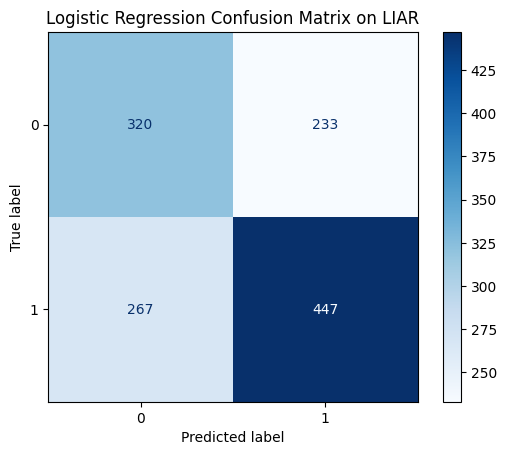


SVM


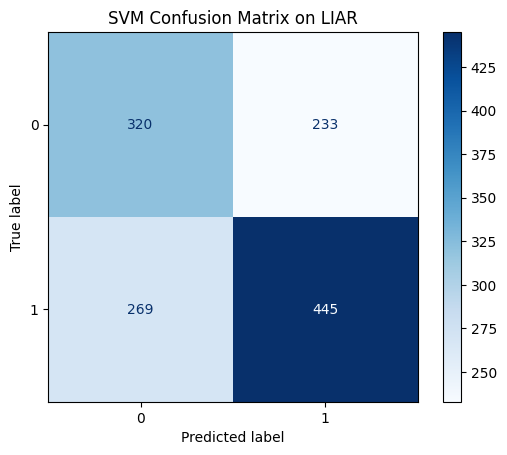


Naive Bayes


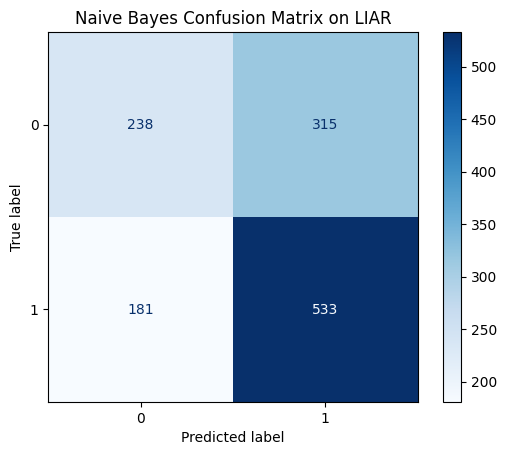


Random Forest


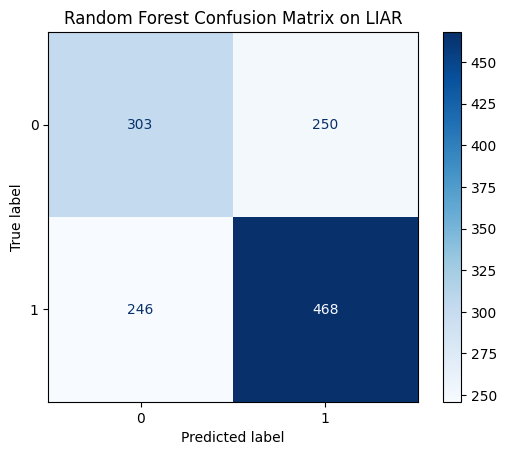

In [36]:
# Evaluate confusion matrix for each model
for name, model in models.items():
    print(f"\n{name}")

    # Make predictions for this model
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int).ravel()

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix on ISOT")
    plt.show()

In [ ]:
# Plot ROC curves for each model
for name, model in models.items():
    print(f"\n{name} ROC Curve")

    # Get model scores
    if hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    elif hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:  # e.g., Keras or models with only predict
        y_scores = model.predict(X_test)
        if y_scores.ndim > 1:  # if output is 2D, take positive class column
            y_scores = y_scores[:, 1]
        y_scores = np.ravel(y_scores)

    # Compute ROC and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
